## Interactive Demo/Outputs for finalPerimsVsInteragency Py script
- Interactive printing for finalized py script
- Not a scratchwork zone; see `NIFCscratchwork` 

date: 19890    20190814
Name: DATE_CUR, dtype: object
william inst date, see if its a time issue: 33451   2019-08-10 12:00:00
Name: t, dtype: datetime64[ns]
william inst date, see if its a time issue: 33452   2019-08-09
Name: t, dtype: datetime64[ns]
william inst date, see if its a time issue: 33453   2019-08-08 12:00:00
Name: t, dtype: datetime64[ns]
william inst date, see if its a time issue: 33454   2019-08-08 12:00:00
Name: t, dtype: datetime64[ns]
william inst date, see if its a time issue: 33455   2019-08-08 12:00:00
Name: t, dtype: datetime64[ns]
william inst date, see if its a time issue: 33456   2019-08-08 12:00:00
Name: t, dtype: datetime64[ns]
william inst date, see if its a time issue: 33457   2019-08-08 12:00:00
Name: t, dtype: datetime64[ns]
william inst date, see if its a time issue: 33458   2019-08-08
Name: t, dtype: datetime64[ns]
william inst date, see if its a time issue: 33459   2019-08-07 12:00:00
Name: t, dtype: datetime64[ns]
william inst date, see if its a time 

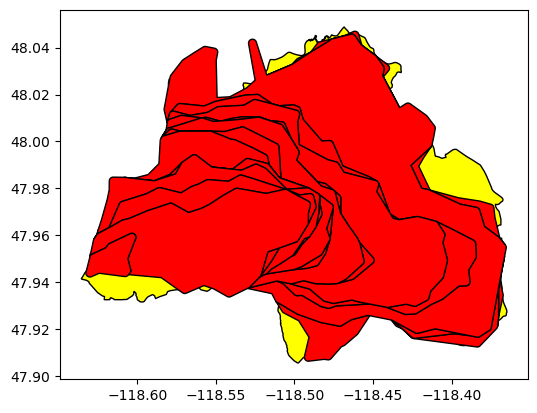

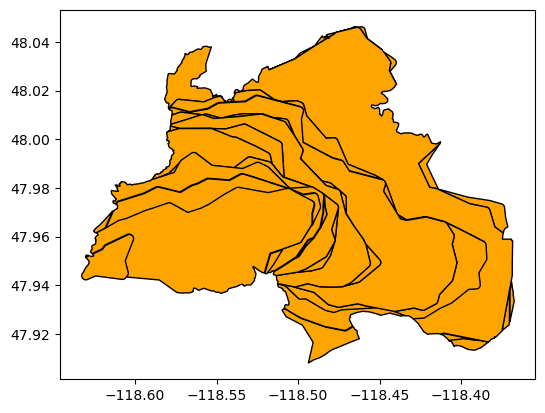

In [2]:
# try: fetch manually the nifc williams incident
# plot against identified fire lines
manual_find = finalized_perims[finalized_perims.INCIDENT == "Williams Flats"].head()
# print(manual_find)
print(f'date: {manual_find.iloc[[0]].DATE_CUR}')
ax = manual_find.plot(facecolor="yellow", edgecolor="black", legend=True)

ax_fidd_time = True

for instance in range(finalized_williams.shape[0]):
    print(f'william inst date, see if its a time issue: {finalized_williams.iloc[[instance]].t}')
    finalized_williams.iloc[[instance]].plot(facecolor="red", edgecolor="black", ax=ax)
    # calculate intersect
    resulting = gpd.overlay(manual_find,finalized_williams.iloc[[instance]], how='intersection')
    if ax_fidd_time:
        axy_new = resulting.plot(facecolor="orange", edgecolor="black")
        ax_fidd_time = False
    else:
        resulting.plot(facecolor="orange", edgecolor="black", ax=axy_new)

BENCHMARKING: EVOLVING FIRE PERIM V. MODE
Attempting set_crs (nifc)...
Attempting set_crs (FEDS)...
VERBOSE DEBUG: DATE NOT NONE PRINT
0        True
1        True
2        True
3        True
4        True
         ... 
24742    True
24743    True
24744    True
24745    True
24746    True
Length: 24745, dtype: bool


/projects/env-feds/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/projects/env-feds/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Per FEDS output, identify best NIFC match...


  0%|          | 0/32 [00:00<?, ?it/s]

VERBOSE: print find_nearest variables:
date value of william
2019-08-14 00:00:00
best value matches/mins by distance
2019-08-10 00:00:00
finalized set from min res


  0%|          | 0/32 [00:00<?, ?it/s]

       OBJECTID              MAP_METHOD  DATE_CUR  \
395         396    Image Interpretation  20190810   
396         397  Remote Sensing Derived  20190810   
18829     18830                    None  20190810   

                                                COMMENTS GEO_ID  \
395    Perimeter updated using Sentinel-2 Image Servi...    396   
396    Perimeter digitized using Sentinel 2 image col...    397   
18829  Engine 2462 discovered an old roadside fire, c...   1726   

                                      IRWINID         UNQE_FIRE_ FIRE_YEAR  \
395    {8348636A-BC59-43B8-BCA8-E620847A948F}  2019-AKUYD-000217      2019   
396    {C73013C8-BEBD-4465-8999-D75E34E7D55D}  2019-AKGAD-000614      2019   
18829                                    None    2019-TXLGR-2053      2019   

      LOCAL_NUM       INCIDENT UNIT_ID POO_RESP_I                FEATURE_CA  \
395      000217  Yukon Charley   AKYCP      AKUYD  Wildfire Final Perimeter   
396      000614  Norutak Hills   AKGAP      AKG

Exception: No williams contained in matched

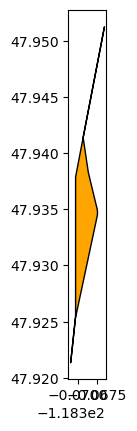

In [1]:
# activate env-feds env
import osgeo
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import xarray as xr
import rasterio
import glob
import shapely.speedups
import warnings
import folium
import boto3
import botocore

from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
from datetime import datetime
from tqdm import tqdm # add in progress watch
from matplotlib import pyplot as plt
from osgeo import ogr

# @NOTE: rename "finalized_williams" var to elim confusion for generalized v.

# CONSTANTS
perims_path = "/projects/my-public-bucket/InterAgencyFirePerimeterHistory"
williams_final_path = '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/*4655*'
usa_path = "/projects/my-public-bucket/USAShapeFile"

# alternative reading
files = glob.glob("/projects/shared-buckets/ashiklom/WesternUS/files_for_paper/*_.geojson")
data_all = pd.concat([gpd.read_file(file) for file in files],ignore_index=True)

# @TODO: call path validity checks after f complete

# if want to use extent set
geojson_use = True
geojson_keyword = 'WILLIAMS FLATS' # 'KINCADE' # 'WILLIAMS FLATS' 

default_crs = 'epsg:4326' #'epsg:9311' # universal crs for all geoms
unit_dict = {'epsg:9311': 'metre', 'epsg:4326':'degree'}
unit_preference = unit_dict[default_crs] # unit of choice @TODO double check plot impact

use_final = False
layer = 'perimeter'
ascending = False # NOTE: use var as indicator for plot ordering
date_column = 'DATE_CUR' # column corresponding to source date of perim (i.e. date for comparison against output) 
curr_dayrange = 5 # day range search; values [0,7] available, 1 recommended for 0 hour <-> 12 hour adjustments

apply_Wildfire_Final_Perimeter = False # apply the NIFC label - WARNING: unreliable given inconsistency
simplify_tolerance = 100 # user selected tolerance upper bound

# FUNCTION DEFINITIONS

# @TODO: FINISH CHECK -add s3 path/validity check w boto3
def path_exists(path, ptype):
    """ Check if path exists (regular OS or s3)
            path == url to check
            ptype == "reg" vs "s3"
        return: boolean
    """
    
    if ptype == 's3':
        # @TODO: fix s3 check (unable to load in)
        s3 = boto3.resource('s3')

        try:
            s3.Object(directory, object_file).load()
            return True 
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == "404":
                # The object does not exist.
                assert -1 == 0, "Failed s3 reading, object DNE"
                return False
            else:
                assert -1 == 0, "Failed s3 reading, non 404."
                return False
    else:
        # @TODO: run regular os check
        return False

def get_nearest(dataset, timestamp, dayrange):
    """ Identify rows of dataset with timestamp matches;
        expects year, month, date in datetime format
            dataset: input dataset to search for closest match
            timestamp: timestamp we want a close match for
        returns: dataset with d->m->y closest matches
        
        for manual intervention
        INCIDENT.item() == 'Williams Flats'
    """
    assert dayrange < 8, "Excessive provided day range; select smaller search period."
    
    timestamp = timestamp.item()
    # @NOTE: DATE_CUR_STAMP shouldnt be exclusive to interagency perims
    transformed = dataset.DATE_CUR_STAMP.tolist()

    clos_dict = {
      abs(timestamp.timestamp() - date.timestamp()) : date
      for date in transformed
    }
    
    print('VERBOSE: print find_nearest variables:')
    dataset_with_will = dataset[dataset.INCIDENT == 'Williams Flats']
    assert not dataset_with_will.empty, "dataset without modification has no williams flats"
    # print('clos_dict:')
    # print(clos_dict)
    print('date value of william')
    print(dataset_with_will.iloc[[0]].DATE_CUR_STAMP.item())

    res = clos_dict[min(clos_dict.keys())]
    # print("Nearest date: " + str(res))
    
    print('best value matches/mins by distance')
    print(res)
    
    # check on dayrange flexibility
    if abs(timestamp.day - res.day) > dayrange and dayrange == 7:
        # trigger exception
        return None
    
    assert abs(timestamp.day - res.day) <= dayrange, "No dates found in specified range; try a more flexible range by adjusting `dayrange` var"
    
    # fetch rows with res timestamp
    finalized = dataset[dataset['DATE_CUR_STAMP'] == res]
    
    print('finalized set from min res')
    print(finalized)
    
    return finalized

# @TODO: implement recursive function on 
def best_simplification(feds, nifc, top_performance, top_tolerance, base_tolerance):
    if base_tolerance == 0:
        return top_tolerance
    
    # reduce for recursive case
    base_tolerance -= 1
    return best_simplification(feds, nifc, top_performance, top_tolerance, base_tolerance)

# @TODO: implement error calculation relative to FEDS output
def error_calc_feds():
    return None

# @TODO: implement error calculation relative to outside source (nifc)
def error_calc_nifc():
    return None

# MAIN CODE 

# change the global options that Geopandas inherits from
# gpd method (comp. slower)
pd.set_option('display.max_columns',None)

# read nifc perims + us
df = gpd.read_file(perims_path)
usa = gpd.read_file(usa_path)

# basic filtering
# remove none geometry 
non_empty = df[df.geometry != None]
# remove null acres
non_null = non_empty[non_empty.GIS_ACRES != 0]
finalized_perims = non_null
# NOTE: filtering by 'final' label established by NIFC is UNRELIABLE!
if apply_Wildfire_Final_Perimeter:
    print(f'WARNING: {apply_Wildfire_Final_Perimeter} is true; may severely limit search results.')
    finalized_perims = non_empty[non_empty.FEATURE_CA == 'Wildfire Final Perimeter']

if geojson_use:
    # check selected key in list
    all_names = data_all['Name'].tolist()
    assert geojson_keyword in all_names, "Selected geojson_keyword not in GeoJson, check constants."
    # read geojson
    gdf = data_all[data_all['Name']==geojson_keyword].copy()
    gdf = gdf.sort_values(by='t',ascending=ascending)
else: 
    # Williams ID based path
    lf_files = glob.glob(williams_final_path)
    # unique lf ids if more than one, but works with only one too!
    lf_ids = list(set([file.split('Largefire/')[1].split('_')[0] for file in lf_files])) 
    print('Number of LF ids:',len(lf_ids)) # Should be one, just william's flats

    # save set of fire(s) into single var depending on mode

    print('VERBOSE: print lf_ids')
    print(lf_ids)
    print('LAST ELEMENT OF LIST')
    print(lf_ids[-1])
    print('BUG: returning empty list... fire doesnt seem to exist...')

    # temporary check
    assert len(lf_ids) != 0, "lf_ids is empty, halt algorithm."

    # extract latest entry by ID
    largefire_dict = dict.fromkeys(lf_ids)

    for lf_id in lf_ids:
        most_recent_file = [file for file in lf_files if lf_id in file][-1]
        largefire_dict[lf_id] = most_recent_file

    gdf = gpd.read_file(largefire_dict[lf_id],layer=layer)
    # sort by descending time (latest to newest)
    gdf = gdf.sort_values(by='t',ascending=ascending)

if use_final:
    print('BENCHMARKING: FINAL PERIM V. MODE')
    # read perimeter of existing line
    fid = lf_ids[0]
    max_timestamp = gdf.t.max()
    gdf = gdf[gdf.t == max_timestamp]
    # rename for convennience
    finalized_williams = gdf.iloc[[0]]
    assert finalized_williams.shape[0] == 1, "Somethings wrong, multiple perims detected..."
    # extract year for filtering
    extracted_year = max_timestamp.year
    
    
else:
    # @TODO: YEAR CHECK
    print('BENCHMARKING: EVOLVING FIRE PERIM V. MODE')
    mul_years = False
    finalized_williams = gdf 
    # check year uniformity
    sample_year = finalized_williams.iloc[[0]].t.max().year
    year_matching = [sample_year ==  finalized_williams.iloc[[j]].t.max().year for j in range(finalized_williams.shape[0])]
    # if there was any mismatch, flag for difference
    if False in year_matching:
        print('WARNING: Current LargeFire contains 2+ years; NIFC filtering impacted.')
        mul_years = True
        # start edge case
        # @TODO: update handling of edge case for filtering
        # print(f'all picked up timestamps: {finalized_williams.t.tolist()}')
        # iterate and print years for mismatch
        for l in range(finalized_williams.shape[0]):
            year_fetch = finalized_williams.iloc[[l]].t.item().year
            if year_fetch != sample_year:
                print(f'failed year: sample was {sample_year} while {year_fetch} was detected.')
            
        assert not mul_years, "@TODO: catch edge case for years; force halt for now."

# print('VERBOSE: DEBUGGING MODE')
# print('full set of gdf')
# print(finalized_williams)
# print('t of full gdf')
# print(finalized_williams.t.tolist())

        
# adjust CRS - nifc
# default_crs
try:
    print('Attempting set_crs (nifc)...')
    finalized_perims.set_crs(default_crs)
except: 
    print('Failure: attempting to_crs application')
    finalized_perims = finalized_perims.to_crs(default_crs)
    print(finalized_perims.crs)

# adjust FEDS crs 
try:
    print('Attempting set_crs (FEDS)...')
    finalized_williams.set_crs(default_crs)
except: 
    print('Failure: attempting to_crs application')
    finalized_williams = finalized_williams.to_crs(default_crs)
    print(finalized_williams.crs)

# unit/crs check
assert finalized_williams.crs == finalized_perims.crs, "CRS mismatch"
assert finalized_williams.crs.axis_info[0].unit_name == unit_preference, f"finalized_williams fails unit check for: {unit_preference}, current units: {finalized_williams.crs.axis_info[0].unit_name}"
assert finalized_perims.crs.axis_info[0].unit_name == unit_preference, f"finalized_perims fails unit check for: {unit_preference}"

# filter by year if year available
try:
    extracted_year
    year_perims = finalized_perims[finalized_perims.FIRE_YEAR == str(extracted_year)]
except NameError:
    print('WARNING: No year extracted from FEDS output. Setting to None. No year reduction applied.')
    extracted_year = None 
    year_perims = finalized_perims

# root out none types
print('VERBOSE DEBUG: DATE NOT NONE PRINT')
print(year_perims.apply(lambda row : row.DATE_CUR is not None, axis = 1))

year_perims['DATE_NOT_NONE'] = year_perims.apply(lambda row : row.DATE_CUR is not None, axis = 1)
year_perims = year_perims[year_perims.DATE_NOT_NONE == True]

# root out long-len date instances
# @TODO: origin of these dates? just wrong user control? way to salvage them reliably?
try:
    year_perims['DATE_LEN_VALID'] = year_perims.apply(lambda row : len(row.DATE_CUR) == 8 , axis = 1)
    year_perims = year_perims[year_perims.DATE_LEN_VALID == True]
except TypeError as e: 
    # if none detected, missed by filtering - check non existence
    print('Invalid type passed for lenght validation; check for Nones in set')
    

# transform NIFC str to new datetime object
cur_format = '%Y%m%d' 
year_perims['DATE_CUR_STAMP'] =  year_perims.apply(lambda row : datetime.strptime(row.DATE_CUR, cur_format), axis = 1)

# nifc-perim pairs as tuples
# i.e. (perimeter FEDS instance, NIFC match)
comparison_pairs = []

axy_exists = False

# per FEDS output perim -> get best NIFC match(es) by date
print('Per FEDS output, identify best NIFC match...')
for instance in tqdm(range(finalized_williams.shape[0])):
    
    # ADDED: make cumulatiev plot 
    if not axy_exists:
        axy_exists = True
        axy = finalized_williams.iloc[[instance]].plot(facecolor="orange", edgecolor="black")
    else:
        finalized_williams.iloc[[instance]].plot(facecolor="orange", edgecolor="black", ax=axy)
        
    # extract time stamp
    timestamp = finalized_williams.iloc[[instance]].t
    
    # query matching nifc with year-month-day form
    # year-month-day matches
    matches = get_nearest(year_perims, timestamp, curr_dayrange)
    
    if matches is None:
        # @TODO: improve handling -> likely just continue and report failed benching
        raise Exception('FAILED: No matching dates found even with 7 day window, critical benchmarking failure.')
        
    # manual checker
    contains_williams = [matches.iloc[[a_m]].INCIDENT.item()== 'Williams Flats' for a_m in range(matches.shape[0])]
    if True not in contains_williams:
        raise Exception('No williams contained in matched')
        
    # intersect closest day matches - ideally size one
    intersd = []
    # find all matches with intersections 
    # for a_match in matches:
    for a_m in range(matches.shape[0]):
    
        # set using index
        a_match = matches.iloc[[a_m]]
        resulting = gpd.overlay(a_match,finalized_williams.iloc[[instance]], how='intersection')
        
        if a_match.INCIDENT.item() == 'Williams Flats':
            print('VERBOSE: nifc manually ran into williams incident')
            ax_cur = a_match.plot(facecolor="yellow", edgecolor="black")
            finalized_williams.iloc[[instance]].plot(facecolor="red", edgecolor="black")
        
        """
        # added: plot results
        ax = a_match.plot(facecolor="yellow", edgecolor="black", legend=True) 
        finalized_williams.iloc[[instance]].plot(facecolor="red", edgecolor="black", ax=ax)
        # try: indvi plots - yellow == nifc, wiliams == red
        a_match.plot(facecolor="yellow", edgecolor="black")
        finalized_williams.iloc[[instance]].plot(facecolor="red", edgecolor="black")
        """
        
        # if non empty -> append
        if not resulting.empty:
            # @NOTE: do NOT append the intersection; want original object only
            intersd.append(a_match)
    
    if len(intersd) == 0:
        print(f'WARNING: Perim master row ID: {finalized_williams.iloc[[instance]].index} at index {instance} as NO INTERSECTIONS at closest date. Storing and will report 0 accuracy.')
        comparison_pairs.append((finalized_williams.iloc[[instance]], None))
        
    
    elif len(intersd) > 1:
        # if multiple have overlay -> store them with a warning 
        print(f'NOTICE: More thane 1, in total: {len(matches)} NIFC date matches, intersect with perimeter master row ID: {finalized_williams.iloc[[instance]].index} with index in finalized_willaims: {instance}, storing all as pairs')
        
        # iterate and generate tuple pairs; append to list
        [comparison_pairs.append((finalized_williams.iloc[[instance]], to_ap)) for to_ap in intersd]
            
    else:
        # single match -> append (perim instance, NIFC single match)
        comparison_pairs.append((finalized_williams.iloc[[instance]], intersd[0]))

# @NOTE: consider reworking store situation - iterating over list can be time consuming for feds perims
error_percent_performance = []
# @TODO: store corresponding performance per single difference
makeup_feds = []
makeup_nifc = [] 
  

# @TODO ACCURACY CALCULATION: per pair run comparison
# calculate symmetrical difference
for nifc_perim_pair in comparison_pairs:
    
    # 0: feds instance, 1: nifc matces
    perim_inst = nifc_perim_pair[0]
    nifc_inst = nifc_perim_pair[1]
    
    # if none type, append 0 accuracy and cont
    if nifc_inst is None:
        error_percent_performance.append(100)
        continue
    
    sym_diff = perim_inst.symmetric_difference(nifc_inst, align=False)
    
    # use item() to fetch int out of values
    assert sym_diff.shape[0] == 1, "Multiple sym_diff entries identified; pair accuracy evaluation will fail."
    
    # calculate error percent: (difference / "correct" shape aka nifc)*100
    error_percent = (sym_diff.geometry.area.item() / nifc_inst.geometry.area.item())*100
    # align calculations by index -> zip n store at end
    error_percent_performance.append(error_percent)



# @NOTE: end for now just to see outputs
print('-----------------')
print('ANALYSIS COMPLETE')
print('-----------------')

assert len(error_percent_performance) == len(comparison_pairs), "Mismatching dims for error performance v. comparison pairs, check resulting arrays"

print('Resulting error percentages for FEDS perimeter accuracy vs. closest intersecting NIFC:')
count_100 = 0
count_100_dates = []
for index in range(len(error_percent_performance)):
    # fetch inst + components by index
    sam = error_percent_performance[index]
    match_tuple = comparison_pairs[index]
    perim_output = match_tuple[0]
    nifc_perim = match_tuple[1]
    
    if sam == 100:
        # count and append date
        count_100 += 1
        count_100_dates.append(perim_output.t.item())
    else:
        print(f'For FEDS output perimeter at {perim_output.t.item()} and NIFC perimeter at {nifc_perim.DATE_CUR_STAMP.item()}, percent error of:')
        print(f'{sam}%')
print(f'{count_100} instances of 100% error')
print('FEDS output perimeter dates with no matches by threshold:')
print(count_100_dates)

# @TODO: implement proper units -> currently list w/ switch cases
    
# @TODO: ideal storage ideas? 
# idea: generate ipynb for visualization? 
# need to replace/write over if duplicates exist

# access to alternative FEDS OUTPUT? 

# new code version

Number of LF ids: 1
BENCHMARKING: EVOLVING FIRE PERIM V. MODE
Attempting set_crs (nifc)...
Attempting set_crs (FEDS)...
Failure: attempting to_crs application
epsg:4326


/projects/env-feds/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Per FEDS output, identify best NIFC match...


 14%|█▍        | 1/7 [00:06<00:40,  6.70s/it]

 29%|██▊       | 2/7 [00:13<00:33,  6.73s/it]

 43%|████▎     | 3/7 [00:20<00:27,  6.75s/it]

 57%|█████▋    | 4/7 [00:26<00:20,  6.76s/it]

 71%|███████▏  | 5/7 [00:33<00:13,  6.76s/it]

 86%|████████▌ | 6/7 [00:40<00:06,  6.77s/it]

100%|██████████| 7/7 [00:47<00:00,  6.76s/it]

-----------------
ANALYSIS COMPLETE
-----------------
Resulting error percentages for FEDS perimeter accuracy vs. closest intersecting NIFC:
7 instances of 100% error
FEDS output perimeter dates with no matches by threshold:
[Timestamp('2019-08-30 12:00:00'), Timestamp('2019-08-30 00:00:00'), Timestamp('2019-08-29 12:00:00'), Timestamp('2019-08-29 00:00:00'), Timestamp('2019-08-28 12:00:00'), Timestamp('2019-08-28 00:00:00'), Timestamp('2019-08-27 12:00:00')]


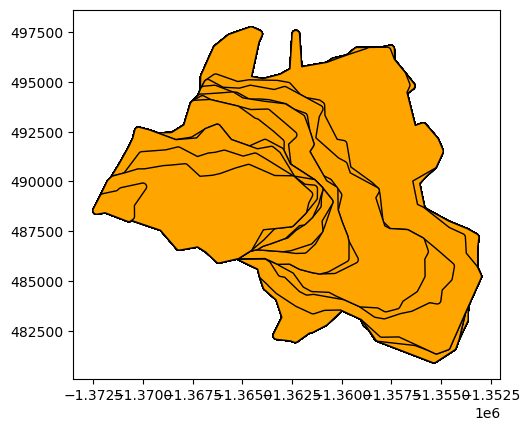

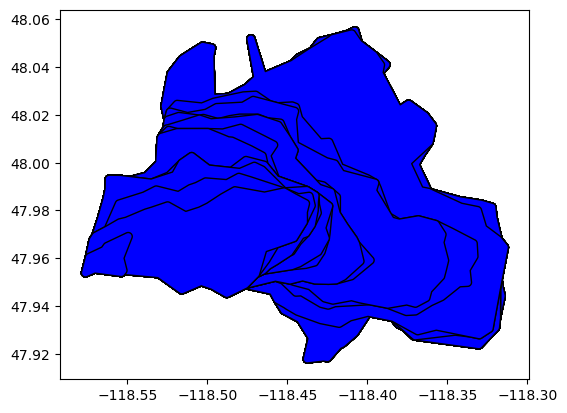

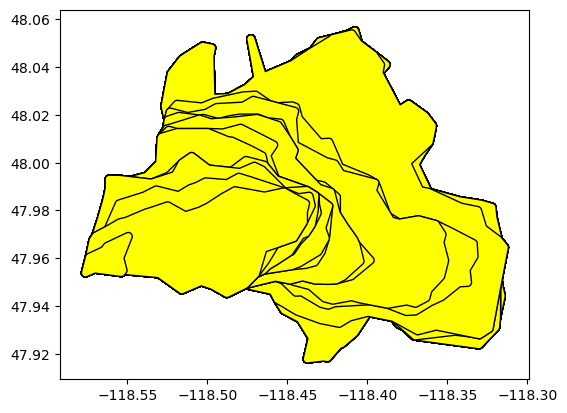

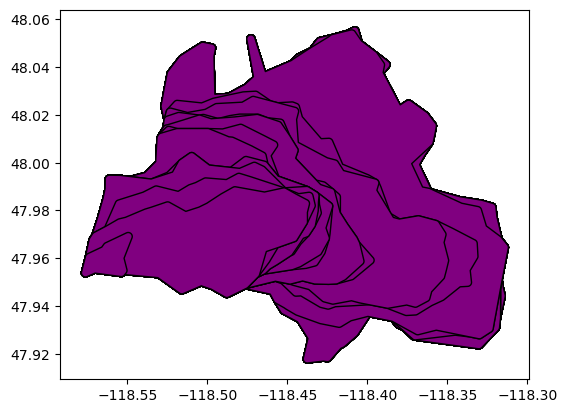

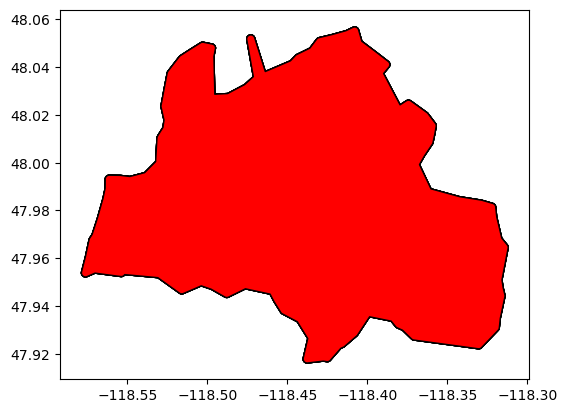

In [15]:
# activate env-feds env
import osgeo
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import xarray as xr
import rasterio
import glob
import shapely.speedups
import warnings
import folium
import boto3
import botocore

from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
from datetime import datetime
from tqdm import tqdm # add in progress watch
from matplotlib import pyplot as plt
from osgeo import ogr

# @NOTE: rename "finalized_williams" var to elim confusion for generalized v.

# CONSTANTS
perims_path = "/projects/my-public-bucket/InterAgencyFirePerimeterHistory"
williams_final_path = '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/*4655*'
usa_path = "/projects/my-public-bucket/USAShapeFile"

# alternative reading
files = glob.glob("/projects/shared-buckets/ashiklom/WesternUS/files_for_paper/*_.geojson")
data_all = pd.concat([gpd.read_file(file) for file in files],ignore_index=True)

# @TODO: call path validity checks after f complete

# if want to use extent set
geojson_use = False
geojson_keyword = 'WILLIAMS FLATS' # 'KINCADE' # 'WILLIAMS FLATS' 

default_crs = 'epsg:4326' #'epsg:9311' # universal crs for all geoms
unit_dict = {'epsg:9311': 'metre', 'epsg:4326':'degree'}
unit_preference = unit_dict[default_crs] # unit of choice @TODO double check plot impact

use_final = False
layer = 'perimeter'
ascending = False # NOTE: use var as indicator for plot ordering
date_column = 'DATE_CUR' # column corresponding to source date of perim (i.e. date for comparison against output) 
curr_dayrange = 5 # day range search; values [0,7] available, 1 recommended for 0 hour <-> 12 hour adjustments

apply_Wildfire_Final_Perimeter = False # apply the NIFC label - WARNING: unreliable given inconsistency
simplify_tolerance = 100 # user selected tolerance upper bound

# FUNCTION DEFINITIONS

# @TODO: FINISH CHECK -add s3 path/validity check w boto3
def path_exists(path, ptype):
    """ Check if path exists (regular OS or s3)
            path == url to check
            ptype == "reg" vs "s3"
        return: boolean
    """
    
    if ptype == 's3':
        # @TODO: fix s3 check (unable to load in)
        s3 = boto3.resource('s3')

        try:
            s3.Object(directory, object_file).load()
            return True 
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == "404":
                # The object does not exist.
                assert -1 == 0, "Failed s3 reading, object DNE"
                return False
            else:
                assert -1 == 0, "Failed s3 reading, non 404."
                return False
    else:
        # @TODO: run regular os check
        return False

def get_nearest(dataset, timestamp, dayrange):
    """ Identify rows of dataset with timestamp matches;
        expects year, month, date in datetime format
            dataset: input dataset to search for closest match
            timestamp: timestamp we want a close match for
        returns: dataset with d->m->y closest matches
    """
    assert dayrange < 8, "Excessive provided day range; select smaller search period."
    
    timestamp = timestamp.item()
    transformed = dataset.DATE_CUR_STAMP.tolist()

    clos_dict = {
      abs(timestamp.timestamp() - date.timestamp()) : date
      for date in transformed
    }

    res = clos_dict[min(clos_dict.keys())]
    # print("Nearest date: " + str(res))
    
    # check on dayrange flexibility
    if abs(timestamp.day - res.day) > dayrange and dayrange == 7:
        # trigger exception
        return None
    
    assert abs(timestamp.day - res.day) <= dayrange, "No dates found in specified range; try a more flexible range by adjusting `dayrange` var"
    
    # fetch rows with res timestamp
    finalized = dataset[dataset['DATE_CUR_STAMP'] == res]
    
    return finalized

# @TODO: implement reduce/simplify geom
def simplify_geometry(shape, tolerance):
    # keep preserve_topology as default (true)
    assert isinstance(shape, gpd.GeoDataFrame)
    return shape.geometry.simplify(tolerance)

# @TODO: implement recursive function on 
def best_simplification(feds, nifc, top_performance, top_tolerance, base_tolerance):
    if base_tolerance == 0:
        return top_tolerance
    
    # reduce for recursive case
    base_tolerance -= 1
    return best_simplification(feds, nifc, top_performance, top_tolerance, base_tolerance)

# @TODO: implement error calculation relative to FEDS output
def error_calc_feds():
    return None

# @TODO: implement error calculation relative to outside source (nifc)
def error_calc_nifc():
    return None

# MAIN CODE 

# change the global options that Geopandas inherits from
# gpd method (comp. slower)
pd.set_option('display.max_columns',None)

# read nifc perims + us
df = gpd.read_file(perims_path)
usa = gpd.read_file(usa_path)

# basic filtering
# remove none geometry 
non_empty = df[df.geometry != None]
# remove null acres
non_null = non_empty[non_empty.GIS_ACRES != 0]
finalized_perims = non_null
# NOTE: filtering by 'final' label established by NIFC is UNRELIABLE!
if apply_Wildfire_Final_Perimeter:
    print(f'WARNING: {apply_Wildfire_Final_Perimeter} is true; may severely limit search results.')
    finalized_perims = non_empty[non_empty.FEATURE_CA == 'Wildfire Final Perimeter']

if geojson_use:
    # check selected key in list
    all_names = data_all['Name'].tolist()
    assert geojson_keyword in all_names, "Selected geojson_keyword not in GeoJson, check constants."
    # read geojson
    gdf = data_all[data_all['Name']==geojson_keyword].copy()
    gdf = gdf.sort_values(by='t',ascending=ascending)
else: 
    # Williams ID based path
    lf_files = glob.glob(williams_final_path)
    # unique lf ids if more than one, but works with only one too!
    lf_ids = list(set([file.split('Largefire/')[1].split('_')[0] for file in lf_files])) 
    print('Number of LF ids:',len(lf_ids)) # Should be one, just william's flats

    # save set of fire(s) into single var depending on mode

    # temporary check
    assert len(lf_ids) != 0, "lf_ids is empty, halt algorithm."

    # extract latest entry by ID
    largefire_dict = dict.fromkeys(lf_ids)

    for lf_id in lf_ids:
        most_recent_file = [file for file in lf_files if lf_id in file][-1]
        largefire_dict[lf_id] = most_recent_file

    gdf = gpd.read_file(largefire_dict[lf_id],layer=layer)
    # sort by descending time (latest to newest)
    gdf = gdf.sort_values(by='t',ascending=ascending)

if use_final:
    print('BENCHMARKING: FINAL PERIM V. MODE')
    # read perimeter of existing line
    fid = lf_ids[0]
    max_timestamp = gdf.t.max()
    gdf = gdf[gdf.t == max_timestamp]
    # rename for convennience
    finalized_williams = gdf.iloc[[0]]
    assert finalized_williams.shape[0] == 1, "Somethings wrong, multiple perims detected..."
    # extract year for filtering
    extracted_year = max_timestamp.year
    
    
else:
    # @TODO: YEAR CHECK
    print('BENCHMARKING: EVOLVING FIRE PERIM V. MODE')
    mul_years = False
    finalized_williams = gdf 
    # check year uniformity
    sample_year = finalized_williams.iloc[[0]].t.max().year
    year_matching = [sample_year ==  finalized_williams.iloc[[j]].t.max().year for j in range(finalized_williams.shape[0])]
    
    # if there was any mismatch, flag for difference (mul years)
    if False in year_matching:
        print('WARNING: Current LargeFire contains 2+ years; NIFC filtering impacted.')
        mul_years = True
        # start edge case
        # @TODO: update handling of edge case for filtering
        # print(f'all picked up timestamps: {finalized_williams.t.tolist()}')
        # iterate and print years for mismatch
        for l in range(finalized_williams.shape[0]):
            year_fetch = finalized_williams.iloc[[l]].t.item().year
            if year_fetch != sample_year:
                print(f'failed year: sample was {sample_year} while {year_fetch} was detected.')
            
        assert not mul_years, "@TODO: catch edge case for years; force halt for now."
        
        ax_undefined = True

        for i in range(finalized_williams.shape[0]):
            current = finalized_williams.iloc[[i]]
            if ax_undefined:
                ax = current.plot(facecolor="yellow", edgecolor="black", legend=True) 
                ax_undefined = False
            else:
                current.plot(facecolor="green", edgecolor="black", ax=ax)
        
    # else: single year
    assert isinstance(sample_year, int), "sample year fails type match"
    extracted_year = sample_year

# print('VERBOSE: DEBUGGING MODE')
# print('full set of gdf')
# print(finalized_williams)
# print('t of full gdf')
# print(finalized_williams.t.tolist())
ndg = True
for gdf_try in range(gdf.shape[0]):
    if ndg:
        axur = gdf.iloc[[gdf_try]].plot(facecolor="yellow")
        ndg = False
    else:
        gdf.iloc[[gdf_try]].plot(facecolor="orange",edgecolor="black", ax=axur)

        
# adjust CRS - nifc
# default_crs
try:
    print('Attempting set_crs (nifc)...')
    finalized_perims.set_crs(default_crs)
except: 
    print('Failure: attempting to_crs application')
    finalized_perims = finalized_perims.to_crs(default_crs)
    print(finalized_perims.crs)

# adjust FEDS crs 
try:
    print('Attempting set_crs (FEDS)...')
    finalized_williams.set_crs(default_crs)
except: 
    print('Failure: attempting to_crs application')
    finalized_williams = finalized_williams.to_crs(default_crs)
    print(finalized_williams.crs)
    

ax_undefined = True

for i in range(finalized_williams.shape[0]):
    current = finalized_williams.iloc[[i]]
    if ax_undefined:
        ax = current.plot(facecolor="yellow", edgecolor="black", legend=True) 
        ax_undefined = False
    else:
        current.plot(facecolor="blue", edgecolor="black", ax=ax)

# unit/crs check
assert finalized_williams.crs == finalized_perims.crs, "CRS mismatch"
assert finalized_williams.crs.axis_info[0].unit_name == unit_preference, f"finalized_williams fails unit check for: {unit_preference}, current units: {finalized_williams.crs.axis_info[0].unit_name}"
assert finalized_perims.crs.axis_info[0].unit_name == unit_preference, f"finalized_perims fails unit check for: {unit_preference}"

# filter by year if year available
try:
    extracted_year
    year_perims = finalized_perims[finalized_perims.FIRE_YEAR == str(extracted_year)]
    
    ax_undefined = True
    for i in range(finalized_williams.shape[0]):
        current = finalized_williams.iloc[[i]]
        if ax_undefined:
            ax = current.plot(facecolor="yellow", edgecolor="black", legend=True) 
            ax_undefined = False
        else:
            current.plot(facecolor="yellow", edgecolor="black", ax=ax)
    
except NameError:
    print('WARNING: No year extracted from FEDS output. Setting to None. No year reduction applied.')
    extracted_year = None 
    year_perims = finalized_perims
    assert 1==0, "force stop -> make algorithm rely on year? otherwise doesnt seem efficient"

# root out none types
year_perims['DATE_NOT_NONE'] = year_perims.apply(lambda row : row.DATE_CUR is not None, axis = 1)
year_perims = year_perims[year_perims.DATE_NOT_NONE == True]

# root out long-len date instances
# @TODO: origin of these dates? just wrong user control? way to salvage them reliably?
try:
    year_perims['DATE_LEN_VALID'] = year_perims.apply(lambda row : len(row.DATE_CUR) == 8 , axis = 1)
    year_perims = year_perims[year_perims.DATE_LEN_VALID == True]
except TypeError as e: 
    # if none detected, missed by filtering - check non existence
    print('Invalid type passed for lenght validation; check for Nones in set')

# transform NIFC str to new datetime object
cur_format = '%Y%m%d' 
year_perims['DATE_CUR_STAMP'] =  year_perims.apply(lambda row : datetime.strptime(row.DATE_CUR, cur_format), axis = 1)

# nifc-perim pairs as tuples
# i.e. (perimeter FEDS instance, NIFC match)
comparison_pairs = []

# per FEDS output perim -> get best NIFC match(es) by date
print('Per FEDS output, identify best NIFC match...')

undef_inst_ax = True
ax_undefined = True

for i in range(finalized_williams.shape[0]):
    current = finalized_williams.iloc[[i]]
    if ax_undefined:
        ax = current.plot(facecolor="yellow", edgecolor="black", legend=True) 
        ax_undefined = False
    else:
        current.plot(facecolor="purple", edgecolor="black", ax=ax)

for instance in tqdm(range(finalized_williams.shape[0]-50)):
    # plot cumaltive
    if undef_inst_ax:
        axty = finalized_williams.iloc[[instance]].plot(facecolor="yellow", edgecolor="black")
        undef_inst_ax = False
    else:
        finalized_williams.iloc[[instance]].plot(facecolor="red", edgecolor="black", ax=axty)
    
    
    # @TODO: run intersection first with all year_perims
    # @TODO: store all non-zero intersections -> get nearest time stamp set (?)
    # dont want to eliminate all matches that are one day apart
    
    # collection of indices relative to year_perims
    insc_indices = []
    # master matches with intersections/timestemp filtering
    intersd = []
    
    # iterate on all year_perims and inersect
    for insc in range(year_perims.shape[0]):
        # fetch nifc instance
        curr_nifc = year_perims.iloc[[insc]]
        intersect = gpd.overlay(curr_nifc,finalized_williams.iloc[[instance]], how='intersection')
        # cont if empty
        if not intersect.empty:
            insc_indices.append(insc)
        # else: continue
    
    if len(insc_indices) == 0:
        print('WARNING: insc_indices was none -> skipping step')
        continue
    
    # all current indices present get_nearest check opportunities
    # @TODO: change the get_nearest to apply for month...?
    timestamp = finalized_williams.iloc[[instance]].t
    # apply insc_indices to pick out intersect matches
    reduced = year_perims.take(insc_indices)
    # match run with get nearest
    # although its really picky -> try for now
    
    # print(f'VERBOSE: reduced: {reduced}, timestamp: {timestamp}')
    try:
        matches = get_nearest(reduced, timestamp, curr_dayrange)
    except:
        # print('WARNING get_nearest failed: continue in instance comparison')
        # indicates no match in given range -> append to failure list 
        print(f'WARNING: Perim master row ID: {finalized_williams.iloc[[instance]].index} at index {instance} as NO INTERSECTIONS at closest date. Storing and will report 0 accuracy.')
        comparison_pairs.append((finalized_williams.iloc[[instance]], None))
        continue
        
    # all matches should act as intersd -> extract from DF
    if matches is None:
        # @TODO: improve handling -> likely just continue and report failed benching
        raise Exception('FAILED: No matching dates found even with 7 day window, critical benchmarking failure.')
        
    intersd = [matches.iloc[[ing]] for ing in range(matches.shape[0])]
    
    # --------
    
    """
    # extract time stamp
    timestamp = finalized_williams.iloc[[instance]].t
    
    # query matching nifc with year-month-day form
    # year-month-day matches
    matches = get_nearest(year_perims, timestamp, curr_dayrange)
    """
    
    if matches is None:
        # @TODO: improve handling -> likely just continue and report failed benching
        raise Exception('FAILED: No matching dates found even with 7 day window, critical benchmarking failure.')
        
    # intersect closest day matches - ideally size one
    """
    intersd = []
    # find all matches with intersections 
    # for a_match in matches:
    
    for a_m in range(matches.shape[0]):
    
        # set using index
        a_match = matches.iloc[[a_m]]
        
        resulting = gpd.overlay(a_match,finalized_williams.iloc[[instance]], how='intersection')
        # if non empty -> append
        if not resulting.empty:
            # @NOTE: do NOT append the intersection; want original object only
            intersd.append(a_match)
    """
    
    if len(intersd) == 0:
        # print(f'WARNING: Perim master row ID: {finalized_williams.iloc[[instance]].index} at index {instance} as NO INTERSECTIONS at closest date. Storing and will report 0 accuracy.')
        # comparison_pairs.append((finalized_williams.iloc[[instance]], None))
        assert 1==0, "case shouldn't exist, throw exception"
        
    elif len(intersd) > 1:
        # if multiple have overlay -> store them with a warning 
        print(f'NOTICE: More thane 1, in total: {len(matches)} NIFC date matches, intersect with perimeter master row ID: {finalized_williams.iloc[[instance]].index} with index in finalized_willaims: {instance}, storing all as pairs')
        
        # iterate and generate tuple pairs; append to list
        [comparison_pairs.append((finalized_williams.iloc[[instance]], to_ap)) for to_ap in intersd]
            
    else:
        # single match -> append (perim instance, NIFC single match)
        comparison_pairs.append((finalized_williams.iloc[[instance]], intersd[0]))

# @NOTE: consider reworking store situation - iterating over list can be time consuming for feds perims
error_percent_performance = []
# @TODO: store corresponding performance per single difference
makeup_feds = []
makeup_nifc = [] 
  

# @TODO ACCURACY CALCULATION: per pair run comparison
# calculate symmetrical difference
for nifc_perim_pair in comparison_pairs:
    
    # 0: feds instance, 1: nifc matces
    perim_inst = nifc_perim_pair[0]
    nifc_inst = nifc_perim_pair[1]
    
    # if none type, append 0 accuracy and cont
    if nifc_inst is None:
        error_percent_performance.append(100)
        continue
    
    sym_diff = perim_inst.symmetric_difference(nifc_inst, align=False)
    
    # use item() to fetch int out of values
    assert sym_diff.shape[0] == 1, "Multiple sym_diff entries identified; pair accuracy evaluation will fail."
    
    # calculate error percent: (difference / "correct" shape aka nifc)*100
    error_percent = (sym_diff.geometry.area.item() / nifc_inst.geometry.area.item())*100
    # align calculations by index -> zip n store at end
    error_percent_performance.append(error_percent)



# @NOTE: end for now just to see outputs
print('-----------------')
print('ANALYSIS COMPLETE')
print('-----------------')

assert len(error_percent_performance) == len(comparison_pairs), "Mismatching dims for error performance v. comparison pairs, check resulting arrays"

print('Resulting error percentages for FEDS perimeter accuracy vs. closest intersecting NIFC:')
count_100 = 0
count_100_dates = []
for index in range(len(error_percent_performance)):
    # fetch inst + components by index
    sam = error_percent_performance[index]
    match_tuple = comparison_pairs[index]
    perim_output = match_tuple[0]
    nifc_perim = match_tuple[1]
    
    if sam == 100:
        # count and append date
        count_100 += 1
        count_100_dates.append(perim_output.t.item())
    else:
        print(f'For FEDS output perimeter at {perim_output.t.item()} and NIFC perimeter at {nifc_perim.DATE_CUR_STAMP.item()}, percent error of:')
        print(f'{sam}%')
print(f'{count_100} instances of 100% error')
print('FEDS output perimeter dates with no matches by threshold:')
print(count_100_dates)

# @TODO: implement proper units -> currently list w/ switch cases
    
# @TODO: ideal storage ideas? 
# idea: generate ipynb for visualization? 
# need to replace/write over if duplicates exist

# access to alternative FEDS OUTPUT?